In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import random
import paho.mqtt.client as mqtt
import json
import time
from threading import Thread


In [10]:
df = pd.read_csv("C:/Users/HP/Desktop/PBL/Raw_Data.csv")
df = df[['created_at', 'Pressure 1', 'Pressure 2', 'Flow rate']]
sensor_nodes = ['A', 'B', 'C', 'D']
df.head()


,created_at,Pressure 1,Pressure 2,Flow rate
0,2024-05-25T08:31:24+00:00,-2.17577,0.00514,0.13333
1,2024-05-25T08:31:41+00:00,30.23457,0.59530,11.06667
2,2024-05-25T08:31:57+00:00,35.48957,5.49288,12.33333
3,2024-05-25T08:32:13+00:00,36.50723,12.12587,11.73333
4,2024-05-25T08:32:28+00:00,36.61425,12.49448,14.93333


In [11]:
def dijkstra(graph, start):
    queue = [(0, start)]
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous = {node: None for node in graph}
    
    while queue:
        (dist, current_node) = heapq.heappop(queue)
        
        for neighbor, weight in graph[current_node].items():
            new_distance = dist + weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                previous[neighbor] = current_node
                heapq.heappush(queue, (new_distance, neighbor))
    
    return distances, previous


In [12]:
graph = {
    'A': {'B': 4, 'C': 2},
    'B': {'A': 4, 'C': 1, 'D': 5},
    'C': {'A': 2, 'B': 1, 'D': 8},
    'D': {'B': 5, 'C': 8}
}


In [5]:
def on_connect(client, userdata, flags, rc):
    print("Connected to MQTT Broker with result code " + str(rc))
    client.subscribe("water/sensors")

def on_message(client, userdata, msg):
    payload = json.loads(msg.payload)
    print(f"[MQTT] Sensor Update: {payload}")

mqtt_client = mqtt.Client()
mqtt_client.on_connect = on_connect
mqtt_client.on_message = on_message
mqtt_client.connect("broker.hivemq.com", 1883, 60)

mqtt_thread = Thread(target=mqtt_client.loop_forever)
mqtt_thread.start()


C:\Users\HP\AppData\Local\Temp\ipykernel_29568\3183752895.py:9: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  mqtt_client = mqtt.Client()


Connected to MQTT Broker with result code 0
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:31:41+00:00', 'Pressure_1': 30.23457, 'Pressure_2': 0.5953, 'Flow_rate': 11.06667, 'node': 'C'}
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:31:57+00:00', 'Pressure_1': 35.48957, 'Pressure_2': 5.49288, 'Flow_rate': 12.33333, 'node': 'A'}
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:32:13+00:00', 'Pressure_1': 36.50723, 'Pressure_2': 12.12587, 'Flow_rate': 11.73333, 'node': 'C'}
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:32:28+00:00', 'Pressure_1': 36.61425, 'Pressure_2': 12.49448, 'Flow_rate': 14.93333, 'node': 'B'}
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:32:44+00:00', 'Pressure_1': 36.84395, 'Pressure_2': 12.99472, 'Flow_rate': 13.93333, 'node': 'B'}
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:33:02+00:00', 'Pressure_1': 37.16658, 'Pressure_2': 13.74625, 'Flow_rate': 14.4, 'node': 'A'}
[MQTT] Sensor Update: {'timestamp': '2024-05-25T08:33:19+00:00', 'Pre

In [6]:
def simulate_sensor_data():
    for i in range(min(len(df), 20)):
        reading = df.iloc[i]
        payload = {
            "timestamp": reading['created_at'],
            "Pressure_1": reading['Pressure 1'],
            "Pressure_2": reading['Pressure 2'],
            "Flow_rate": reading['Flow rate'],
            "node": random.choice(sensor_nodes)
        }
        mqtt_client.publish("water/sensors", json.dumps(payload))
        time.sleep(1)

simulate_thread = Thread(target=simulate_sensor_data)
simulate_thread.start()


In [7]:
def compute_dynamic_weights(base_graph, flow, pressure1, pressure2):
    dynamic_graph = {}
    factor = (abs(pressure1 - pressure2) + 1) / (flow + 1)
    
    for node in base_graph:
        dynamic_graph[node] = {}
        for neighbor, base_weight in base_graph[node].items():
            dynamic_graph[node][neighbor] = base_weight * factor
    return dynamic_graph

sample = df.iloc[10]
flow = sample['Flow rate']
p1 = sample['Pressure 1']
p2 = sample['Pressure 2']
dynamic_graph = compute_dynamic_weights(graph, flow, p1, p2)
distances, path = dijkstra(dynamic_graph, 'A')
print("Routing Table (Dynamic Weights):", distances)


Routing Table (Dynamic Weights): {'A': 0, 'B': 4.902742, 'C': 3.2684946666666663, 'D': 13.073978666666665}


Shortest distances from source node:
  A: 0.00
  B: 4.90
  C: 3.27
  D: 13.07


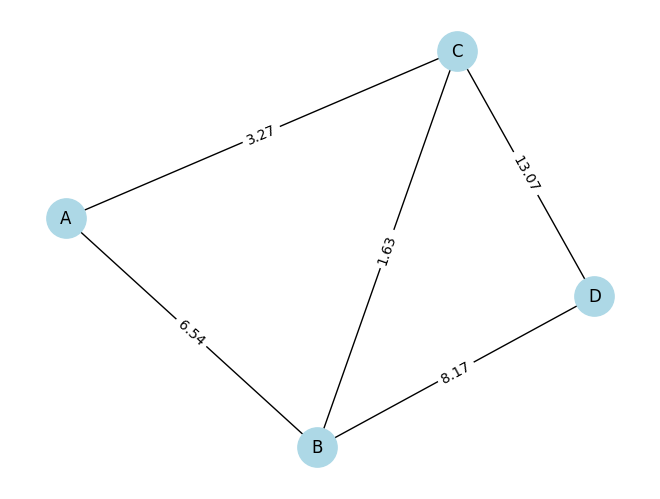

In [8]:
def visualize_graph(graph, distances=None):
    G = nx.Graph()
    for node in graph:
        for neighbor, weight in graph[node].items():
            G.add_edge(node, neighbor, weight=round(weight, 2))
    
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    if distances:
        print("Shortest distances from source node:")
        for node, dist in distances.items():
            print(f"  {node}: {dist:.2f}")
    
    plt.show()

visualize_graph(dynamic_graph, distances)
